#### Here we transform the NetCDF file into standard lists for further analyses 
#### We regrid the spatial resolution onto 2°×2°
#### Historical O${_3}$ simulations 1850-2014 (selecting 2010-2014 for quick observation)

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import iris

#### Prescribe the key parameters: 
##### i) target years for analysis (e.g. Y = 5 for five most recent years 2010-2014)
##### ii) ideal spatial resolutions (e.g. 180×90 grids)
###### These parameters are prescribed arbitrarily

In [2]:
Y = 5
lon = 180
lat = 90

#### Define the 2°×2° new spatial resolution for regridding (centred coordinates)

In [3]:
res_lon = 360/lon
res_lat = 180/lat
sample_points = [('longitude', np.linspace(0+res_lon/2, 360-res_lon/2, lon)),
                 ('latitude',  np.linspace(-90+res_lat/2, 90-res_lat/2, lat))]

In [4]:
sample_points

[('longitude',
  array([  1.,   3.,   5.,   7.,   9.,  11.,  13.,  15.,  17.,  19.,  21.,
          23.,  25.,  27.,  29.,  31.,  33.,  35.,  37.,  39.,  41.,  43.,
          45.,  47.,  49.,  51.,  53.,  55.,  57.,  59.,  61.,  63.,  65.,
          67.,  69.,  71.,  73.,  75.,  77.,  79.,  81.,  83.,  85.,  87.,
          89.,  91.,  93.,  95.,  97.,  99., 101., 103., 105., 107., 109.,
         111., 113., 115., 117., 119., 121., 123., 125., 127., 129., 131.,
         133., 135., 137., 139., 141., 143., 145., 147., 149., 151., 153.,
         155., 157., 159., 161., 163., 165., 167., 169., 171., 173., 175.,
         177., 179., 181., 183., 185., 187., 189., 191., 193., 195., 197.,
         199., 201., 203., 205., 207., 209., 211., 213., 215., 217., 219.,
         221., 223., 225., 227., 229., 231., 233., 235., 237., 239., 241.,
         243., 245., 247., 249., 251., 253., 255., 257., 259., 261., 263.,
         265., 267., 269., 271., 273., 275., 277., 279., 281., 283., 285.,
         2

#### Define the longitude-latitude-temporal sequence list

In [5]:
t = Y*12 ## Y years correspond to 12Y months 

lon_range = np.linspace(0+res_lon/2, 360-res_lon/2, lon)
lat_range = np.linspace(-90+res_lat/2, 90-res_lat/2, lat) 
t_range   = np.linspace(1, t, t) 
lat_mesh, t_mesh, lon_mesh = np.meshgrid(lat_range, t_range, lon_range) 

t_grid   = t_mesh.reshape(t*lon*lat, 1)
lon_grid = lon_mesh.reshape(t*lon*lat, 1)
lat_grid = lat_mesh.reshape(t*lon*lat, 1)

dataset = pd.DataFrame(lon_grid, columns = {'longitude'})
dataset['latitude'] = lat_grid
dataset['t'] = t_grid
dataset['loc'] = dataset['longitude']*1000+dataset['latitude']
dataset

,longitude,latitude,t,loc
0,1.0,-89.0,1.0,911.0
1,3.0,-89.0,1.0,2911.0
2,5.0,-89.0,1.0,4911.0
3,7.0,-89.0,1.0,6911.0
4,9.0,-89.0,1.0,8911.0
...,...,...,...,...
971995,351.0,89.0,60.0,351089.0
971996,353.0,89.0,60.0,353089.0
971997,355.0,89.0,60.0,355089.0
971998,357.0,89.0,60.0,357089.0


#### Import surface/ambient O${_3}$

In [6]:
data = iris.load_cube('/Volumes/Database/CMIP6/MOHC/historical/o3_AERmon_UKESM1-0-LL_historical_r1i1p1f2_gn_200001-201412.nc', 'o3')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
o3 = values.reshape(t*lon*lat,1)
dataset['o3'] = o3

#### We should convert 0-360° into 180°W-180°E scheme

In [7]:
dataset_pt1 = dataset[dataset['longitude'] < 180]
dataset_pt2 = dataset[dataset['longitude'] >= 180]
dataset_pt2['longitude'] = dataset_pt2['longitude']-360
dataset_adj = dataset_pt1.append(dataset_pt2)
dataset_adj

,longitude,latitude,t,loc,o3
0,1.0,-89.0,1.0,911.0,1.589701e-08
1,3.0,-89.0,1.0,2911.0,1.590375e-08
2,5.0,-89.0,1.0,4911.0,1.591221e-08
3,7.0,-89.0,1.0,6911.0,1.594265e-08
4,9.0,-89.0,1.0,8911.0,1.596177e-08
...,...,...,...,...,...
971995,-9.0,89.0,60.0,351089.0,1.630996e-08
971996,-7.0,89.0,60.0,353089.0,1.632853e-08
971997,-5.0,89.0,60.0,355089.0,1.634956e-08
971998,-3.0,89.0,60.0,357089.0,1.636259e-08


In [8]:
dataset_adj['month'] = dataset_adj['t']%12

annual_average = dataset_adj.groupby(['loc']).mean()

dataset_JJA = dataset_adj[dataset_adj['month']>5]
dataset_JJA = dataset_JJA[dataset_JJA['month']<9]

dataset_DJF = dataset_adj[dataset_adj['month']<2]

JJA_average = dataset_JJA.groupby(['loc']).mean()
DJF_average = dataset_DJF.groupby(['loc']).mean()

### Map the variables to ensure correct gridding

(-90.0, 90.0)

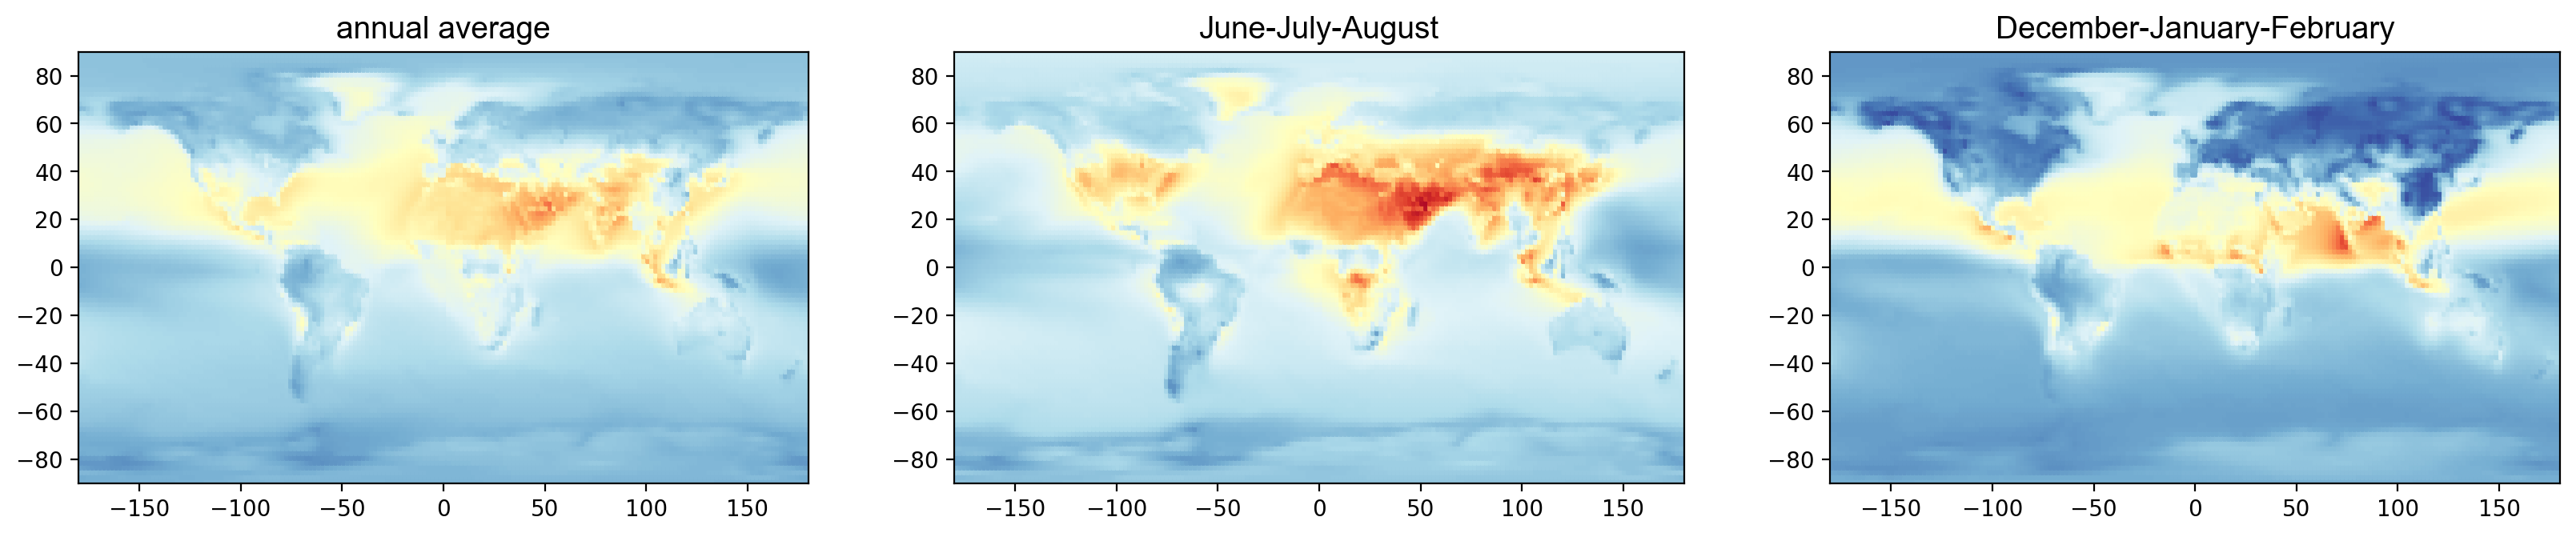

In [9]:
plt.figure(num=None, figsize=(20, 3.5), dpi=200, facecolor='w', edgecolor='k')
cm = plt.cm.get_cmap('RdYlBu_r')
x = annual_average['longitude']
y = annual_average['latitude']

plt.subplot(1,3,1)
plt.title('annual average', fontsize = 14, fontname = "Arial", color = "black")
z = annual_average['o3']*10**9
sc = plt.scatter(x, y, c=z, marker="s", s=5, vmin=0, vmax=80, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(1,3,2)
plt.title('June-July-August', fontsize = 14, fontname = "Arial", color = "black")
z = JJA_average['o3']*10**9
sc = plt.scatter(x, y, c=z, marker="s", s=5, vmin=0, vmax=80, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(1,3,3)
plt.title('December-January-February', fontsize = 14, fontname = "Arial", color = "black")
z = DJF_average['o3']*10**9
sc = plt.scatter(x, y, c=z, marker="s", s=5, vmin=0, vmax=80, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

### Merge and export the dataset for geomapping 

In [10]:
coord = annual_average[['longitude','latitude']]
coord['annual'] = annual_average['o3']*10**9
coord['JJA'] = JJA_average['o3']*10**9
coord['DJF'] = DJF_average['o3']*10**9

#coord.to_csv('Extended Data Fig. 1 ozone-concentration-mapping.csv', index=False)